In [ ]:
# unzip a file dataset in drive
!unzip /content/drive/MyDrive/clf-data.zip -d /content/

In [36]:
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split

# Set parameters
IMAGE_SIZE = (70, 70)
BATCH_SIZE = 32
EPOCHS = 10
DATASET_PATH = "/content/clf-data"

# Get all image paths and labels
class_names = sorted(os.listdir(DATASET_PATH))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(DATASET_PATH, class_name)
    for fname in os.listdir(class_folder):
        if fname.endswith(('.jpg')):
            image_paths.append(os.path.join(class_folder, fname))
            labels.append(class_to_index[class_name])

# Splitting Data

# Step 1: Initial split -> train (70%), temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.30, stratify=labels, random_state=42
)

# Step 2: Split temp into val (15%) and test (15%) -> 0.5 * 30% = 15%
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

# Function to load and preprocess
def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, IMAGE_SIZE[0], IMAGE_SIZE[1])
    return img, tf.one_hot(label, len(class_names))

# Train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Augmentation block
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.RandomFlip("horizontal"),         # Flip horizontally
    tf.keras.layers.RandomRotation(0.2),              # Rotate up to 10%
    tf.keras.layers.RandomZoom(0.2),                  # Zoom in/out
    tf.keras.layers.RandomTranslation(0.2, 0.2),      # Shift images
    tf.keras.layers.RandomContrast(0.2),              # Adjust contrast
])

# Build CNN model
model = tf.keras.Sequential([
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[callback])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 68, 68, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,450 (3.42 MB)

 Trainable params: 896,450 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6832 - loss: 0.5228 - val_accuracy: 0.9803 - val_loss: 0.0470
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9727 - loss: 0.0733 - val_accuracy: 0.9945 - val_loss: 0.0165
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9806 - loss: 0.0559 - val_accuracy: 0.9967 - val_loss: 0.0152
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9875 - loss: 0.0390 - val_accuracy: 0.9967 - val_loss: 0.0078
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9848 - loss: 0.0473 - val_accuracy: 0.9912 - val_loss: 0.0302
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9849 - loss: 0.0442 - val_accuracy: 0.9989 - val_loss: 0.0061
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9866 - loss: 0.0331 - val_accuracy: 0.9989 - val_loss: 0.0088
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9921 - loss: 0.0209 - val_accu

In [37]:
# Evaluate Model on Test Set
loss, acc = model.evaluate(test_ds)
print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.2%}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9939 - loss: 0.0134
Validation Loss: 0.0232, Accuracy: 98.69%


Text(0, 0.5, 'Accuracy')

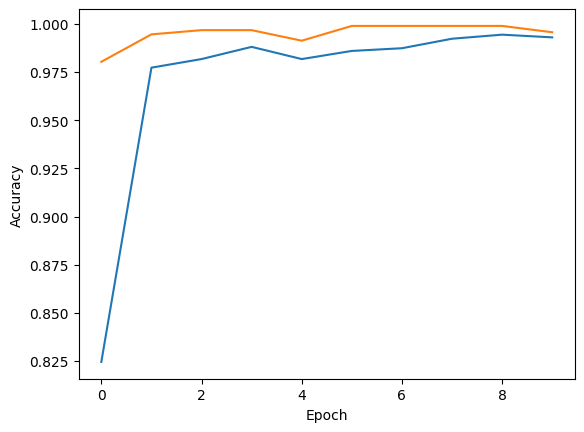

In [38]:
# plotting training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [39]:
# Predict on Individual Images from the Validation Set

import matplotlib.pyplot as plt
import numpy as np

# Pick 10 images from test set
num_images = 10
sample_paths = test_paths[:num_images]
sample_labels = test_labels[:num_images]

# Load and preprocess images
images = []
for path in sample_paths:
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_pad(img, IMAGE_SIZE[0], IMAGE_SIZE[1])
    images.append(img)

images_tensor = tf.stack(images)
predictions = model.predict(images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = sample_labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


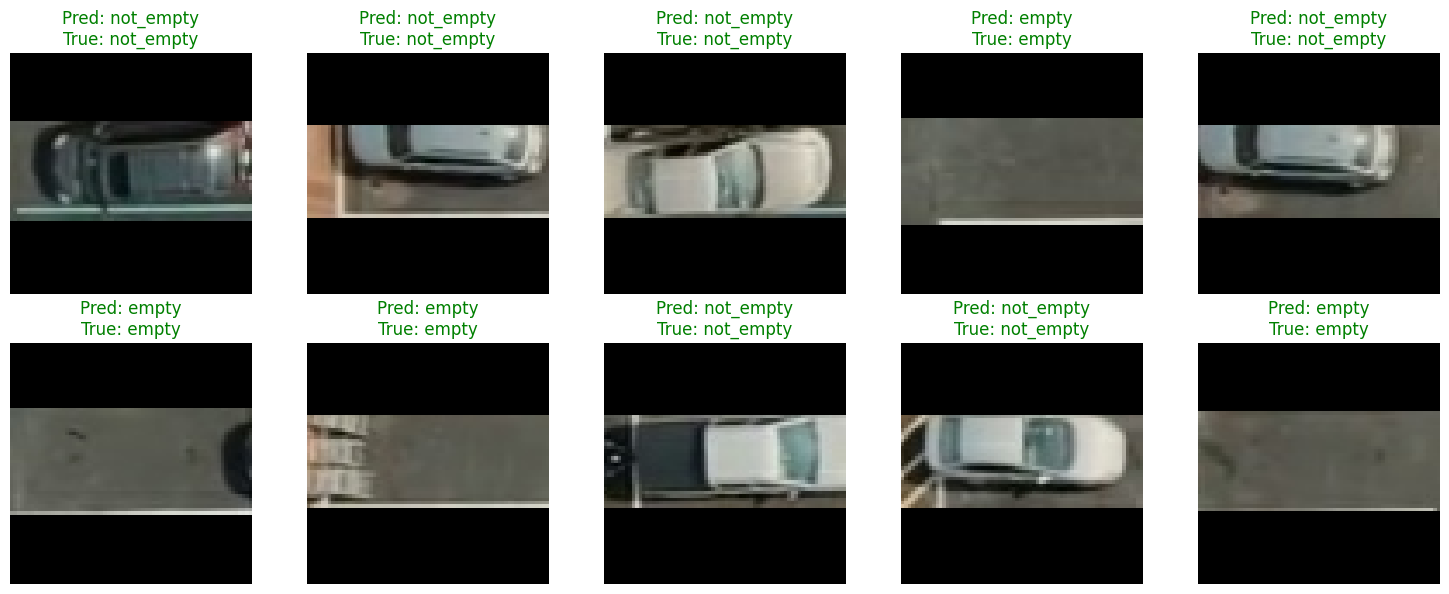

In [40]:
# Plot images with actual and predicted labels
plt.figure(figsize=(15, 6))
for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].numpy())
    plt.axis('off')
    true_label = class_names[true_classes[i]]
    pred_label = class_names[predicted_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
[[8.335445e-09 1.000000e+00]]
Predicted class: not_empty


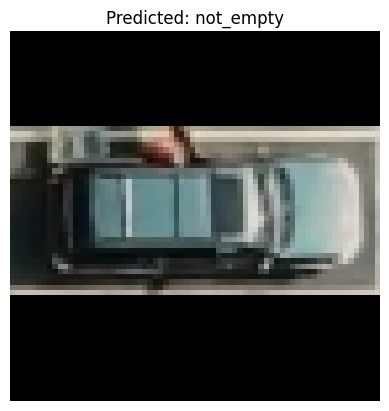

In [42]:
# predict on new images
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # Ensure tensorflow is imported if not already in this cell

# Load and preprocess new images
path = '/content/Screenshot 2025-05-28 011831.png'

img = tf.io.read_file(path)
img = tf.image.decode_image(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize_with_pad(img, IMAGE_SIZE[0], IMAGE_SIZE[1])

# Add a batch dimension to the image
img = tf.expand_dims(img, axis=0)

predict = model.predict(img)
print(predict)

# To get the predicted class name:
predicted_class_index = np.argmax(predict, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")

# Optional: Display the image
plt.imshow(tf.squeeze(img).numpy()) # Remove batch dimension for displaying
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name}")
plt.show()

In [43]:
# Saving the model
model.save('/content/classification_model.h5')